# Vi-T for CIFAR-10

## Import Libraries

In [ ]:
%pip install transformers pygwalker wandb

In [1]:
import os
os.chdir("./tmp/src")

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from transformers import ViTConfig, ViTModel

from ttt.lm.pytorch import Block as TTTBlock, TTTCache, TTTConfig

from torchvision import transforms, datasets, utils

from os import path, rename, mkdir, listdir

from tqdm.notebook import tqdm
import pygwalker as pyg
import wandb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# WandB Initialization
#wandb.init(project="cifar10_pytorch_normal")
wandb.init(project="cifar10_pytorch_ttt")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: brew (brew-research). Use `wandb login --relogin` to force relogin


### Check GPU Availability

In [4]:
!nvidia-smi

Sun Dec  1 12:00:08 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:04:00.0 Off |                    0 |
| N/A   38C    P0    33W / 250W |  15554MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   

In [5]:
# Set CUDA Device Number 0~7
DEVICE_NUM = 5

if torch.cuda.is_available():
    torch.cuda.set_device(DEVICE_NUM)
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    DEVICE_NUM = -1
print(f"INFO: Using device - {device}:{DEVICE_NUM}")

INFO: Using device - cuda:5


## Load DataSets

In [6]:
# Image Resizing and Tensor Conversion
IMG_SIZE = (32, 32)
IMG_NORM = dict(  # CIFAR10 Normalization
    mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]
)

augmenter = transforms.Compose([
    transforms.Resize(IMG_SIZE),  # Resize Image
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=9),
    transforms.ToTensor(),  # Convert Image to Tensor
    transforms.Normalize(**IMG_NORM)  # Normalization
])

resizer = transforms.Compose([
    transforms.Resize(IMG_SIZE),  # Resize Image
    transforms.ToTensor(),  # Convert Image to Tensor
    transforms.Normalize(**IMG_NORM)  # Normalization
])

In [7]:
DATA_ROOT = path.join(".", "data")

train_dataset = datasets.CIFAR10(root=DATA_ROOT, download=True, train=True, transform=augmenter)
test_dataset = datasets.CIFAR10(root=DATA_ROOT, download=True, train=False, transform=resizer)

print(f"INFO: Dataset loaded successfully. Number of samples - Train({len(train_dataset)}), Test({len(test_dataset)})")

Files already downloaded and verified
Files already downloaded and verified
INFO: Dataset loaded successfully. Number of samples - Train(50000), Test(10000)


In [8]:
# Train Dataset Distribution
pyg.walk(pd.DataFrame(dict(lable=[train_dataset.classes[lb] for lb in train_dataset.targets])))

Box(children=(HTML(value='\n<div id="ifr-pyg-000628342cacb2c0HpXiAg76O5uCfyI0" style="height: auto">\n    <hea…

In [9]:
# Test Dataset Distribution
pyg.walk(pd.DataFrame(dict(lable=[test_dataset.classes[lb] for lb in test_dataset.targets])))

Box(children=(HTML(value='\n<div id="ifr-pyg-000628342cb348abgf1q4vtJQpOihVAj" style="height: auto">\n    <hea…

## DataLoader

In [10]:
# Set Batch Size
BATCH_SIZE = 512

In [11]:
MULTI_PROCESSING = True  # Set False if DataLoader is causing issues

from platform import system
if MULTI_PROCESSING and system() != "Windows":  # Multiprocess data loading is not supported on Windows
    import multiprocessing
    cpu_cores = multiprocessing.cpu_count()
    print(f"INFO: Number of CPU cores - {cpu_cores}")
else:
    cpu_cores = 0
    print("INFO: Using DataLoader without multi-processing.")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=cpu_cores)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_cores)

INFO: Number of CPU cores - 48


In [12]:
# Image Visualizer
def imshow(image_list, mean=IMG_NORM['mean'], std=IMG_NORM['std']):
    np_image = np.array(image_list).transpose((1, 2, 0))
    de_norm_image = np_image * std + mean
    plt.figure(figsize=(10, 10))
    plt.imshow(de_norm_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


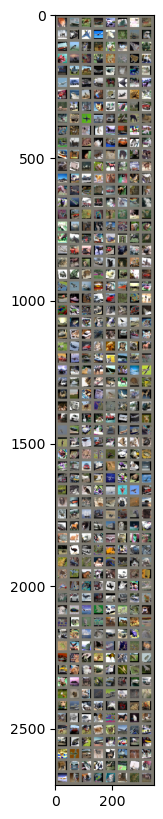

In [15]:
images, targets = next(iter(train_loader))
grid_images = utils.make_grid(images, nrow=8, padding=10)
imshow(grid_images)

## Define Model

In [13]:
common_config = dict(
    image_size=IMG_SIZE[0],
    num_channels=3,
    patch_size=8,
    hidden_size=768,
    num_hidden_layers=6,
    num_attention_heads=8,
    intermediate_size=3072,
    hidden_act="gelu",
    hidden_dropout_prob=0.1,
    attention_probs_dropout_prob=0.1,
    initializer_range=0.02,
    layer_norm_eps=1e-12,
    qkv_bias=True,
    encoder_stride=16
)

### Normal Vi-T

In [14]:
class ViTImageClassifier(nn.Module):
    def __init__(self, config: ViTConfig, num_classes: int):
        super().__init__()
        self.config = config
        self.vit = ViTModel(config=config)
        self.fc = nn.Linear(self.config.hidden_size, num_classes)

    def forward(self, x):
        out = self.vit(x)
        pooled = out.pooler_output  # [batch_size, hidden_size]
        logits = self.fc(pooled)  # [batch_size, num_classes]
        return logits

In [16]:
# Initialize Model
model = ViTImageClassifier(config=ViTConfig(**common_config), num_classes=len(train_dataset.classes))
#model.to(device)
model

ViTImageClassifier(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(8, 8), stride=(8, 8))
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-5): 6 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, o

### TTT Vi-T

In [15]:
class ImagePatchEmbedding(nn.Module):
    def __init__(self, config):
        super().__init__()
        image_size = config.image_size
        patch_size = config.patch_size
        num_channels = config.num_channels
        hidden_size = config.hidden_size

        self.num_patches = (image_size // patch_size) ** 2
        self.projection = nn.Conv2d(num_channels, hidden_size, kernel_size=patch_size, stride=patch_size)

In [16]:
from dataclasses import dataclass
from typing import Tuple, Optional
from transformers.utils import ModelOutput


@dataclass
class VisionModelOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: Optional[torch.FloatTensor] = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None

In [17]:
class TTTViTConfig(TTTConfig):
    def __init__(
            self,
            image_size=224,
            patch_size=16,
            num_channels=3,
            **kwargs
    ):
        super().__init__(**kwargs)
        self.image_size = image_size
        self.patch_size = patch_size
        self.num_channels = num_channels

In [18]:
from ttt.lm.pytorch import TTTPreTrainedModel, RMSNorm


class TTTViTModel(TTTPreTrainedModel):
    def __init__(self, config: TTTViTConfig):
        super().__init__(config)
        self.hidden_size = config.hidden_size

        # Image patch embedding
        self.patch_embed = ImagePatchEmbedding(config)

        # Class token
        self.cls_token = nn.Parameter(torch.zeros(1, 1, config.hidden_size))

        # Position embedding
        num_positions = self.patch_embed.num_patches + 1  # +1 for [CLS] token
        self.pos_embed = nn.Parameter(torch.zeros(1, num_positions, config.hidden_size))

        # TTT layers - reuse from original TTTModel
        self.layers = nn.ModuleList([TTTBlock(config, layer_idx) for layer_idx in range(config.num_hidden_layers)])

        # Layer norm
        self.norm = RMSNorm(config.hidden_size, eps=config.rms_norm_eps)

        # Classification head
        self.head = nn.Linear(config.hidden_size, config.hidden_size)

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
            self,
            pixel_values: torch.FloatTensor,
            labels: Optional[torch.LongTensor] = None,
            output_hidden_states: Optional[bool] = None,
            return_dict: Optional[bool] = None,
            use_cache: Optional[bool] = None,
    ):
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.config.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        # Get patch embeddings
        batch_size = pixel_values.shape[0]
        x = self.patch_embed.projection(pixel_values).flatten(2).transpose(1, 2)

        # Add class token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # Add position embeddings
        x = x + self.pos_embed

        # Process through TTT layers
        all_hidden_states = () if output_hidden_states else None

        for layer in self.layers:
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (x,)

            x = layer(x)

        x = self.norm(x)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (x,)

        # Use [CLS] token for classification
        logits = self.head(x[:, 0])

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + (all_hidden_states,) if output_hidden_states else (logits,)
            return ((loss,) + output) if loss is not None else output

        return VisionModelOutput(
            loss=loss,
            logits=logits,
            hidden_states=all_hidden_states if output_hidden_states else None,
        )

In [19]:
class TTTViTImageClassifier(nn.Module):
    def __init__(self, config: TTTViTConfig, num_classes: int):
        super().__init__()
        self.config = config
        self.vit = TTTViTModel(config=config)
        self.fc = nn.Linear(self.config.hidden_size, num_classes)

    def forward(self, x):
        out = self.vit(x)  # [batch_size, hidden_size]
        logits = self.fc(out.logits)  # [batch_size, num_classes]
        return logits, out.loss

In [20]:
# Initialize Model
model = TTTViTImageClassifier(config=TTTViTConfig(
    **common_config, ttt_base_lr=0.01, mini_batch_size=32, use_gate=True  # TTT learning rate, Enable gating mechanism
), num_classes=len(train_dataset.classes))
model.to(device)

TTTViTImageClassifier(
  (vit): TTTViTModel(
    (patch_embed): ImagePatchEmbedding(
      (projection): Conv2d(3, 768, kernel_size=(8, 8), stride=(8, 8))
    )
    (layers): ModuleList(
      (0-5): 6 x Block(
        (seq_modeling_block): TTTLinear(
          (q_proj): Linear(in_features=768, out_features=768, bias=False)
          (k_proj): Linear(in_features=768, out_features=768, bias=False)
          (v_proj): Linear(in_features=768, out_features=768, bias=False)
          (o_proj): Linear(in_features=768, out_features=768, bias=False)
          (g_proj): Linear(in_features=768, out_features=768, bias=False)
          (post_norm): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        )
        (mlp): SwiGluMLP(
          (gate_proj): Linear(in_features=768, out_features=3072, bias=False)
          (up_proj): Linear(in_features=768, out_features=3072, bias=False)
          (down_proj): Linear(in_features=3072, out_features=768, bias=False)
          (act_fn): GELUActivatio

## Training Loop

In [21]:
from IPython.display import display
import ipywidgets as widgets

# Interactive Loss Plot Update
def create_plot():
    losses = []

    # Enable Interactive Mode
    plt.ion()

    # Loss Plot Setting
    fig, ax = plt.subplots(figsize=(6, 2))
    line, = ax.plot(losses)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    ax.set_title("Cross Entropy Loss")

    # Display Plot
    plot = widgets.Output()
    display(plot)

    def update_plot(new_loss):
        losses.append(new_loss.item())
        line.set_ydata(losses)
        line.set_xdata(range(len(losses)))
        ax.relim()
        ax.autoscale_view()
        with plot:
            plot.clear_output(wait=True)
            display(fig)

    return update_plot

In [22]:
def valid_loader_creator():
    while True:
        for data in test_loader:
            yield data

### Normal Vi-T

In [25]:
# Set Epoch Count & Learning Rate
EPOCHS = 40
LEARNING_RATE = 1e-3

criterion = nn.CrossEntropyLoss()
wandb.watch(model, criterion, log="all", log_freq=10)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [ ]:
train_length, valid_length = len(train_loader), 10
valid_loader = iter(valid_loader_creator())

epochs = tqdm(range(EPOCHS), desc="Running Epochs")
with (tqdm(total=train_length, desc="Training") as train_progress,
        tqdm(total=valid_length, desc="Validation") as valid_progress):  # Set up Progress Bars
    update = create_plot()  # Create Loss Plot

    for epoch in epochs:
        train_progress.reset(total=train_length)
        valid_progress.reset(total=valid_length)

        train_acc, train_loss = 0, 0

        # Training
        model.train()
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss += loss.item() / train_length
            corrects = (torch.max(outputs, 1)[1] == targets.data).sum()
            train_acc += corrects / len(train_dataset)

            update(loss)
            train_progress.update(1)
            if i != train_length-1: wandb.log({'Acc': corrects/len(inputs)*100, 'Loss': loss.item()})
            print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Step [{i+1:2}/{train_length}], Acc: {corrects/len(inputs):.6%}, Loss: {loss.item():.6f}", end="")

        print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Step [{train_length}/{train_length}], Acc: {train_acc:.6%}, Loss: {train_loss:.6f}", end="")
        val_acc, val_loss = 0, 0

        # Validation
        model.eval()
        with torch.no_grad():
            for (inputs, targets), _ in zip(valid_loader, range(valid_length)):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)

                val_loss += criterion(outputs, targets).item() / valid_length
                val_acc += (torch.max(outputs, 1)[1] == targets.data).sum() / (len(inputs) * valid_length)
                valid_progress.update(1)

        wandb.log({'Train Acc': train_acc*100, 'Train Loss': train_loss, 'Val Acc': val_acc*100, 'Val Loss': val_loss})
        print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Step [{train_length}/{train_length}], Acc: {train_acc:.6%}, Loss: {train_loss:.6f}, Valid Acc: {val_acc:.6%}, Valid Loss: {val_loss:.6f}", end="\n" if (epoch+1) % 5 == 0 or (epoch+1) == EPOCHS else "")

### TTT Vi-T

In [23]:
# Set Epoch Count & Learning Rate
EPOCHS = 40
LEARNING_RATE = 1e-3

criterion = nn.CrossEntropyLoss()
wandb.watch(model, criterion, log="all", log_freq=10)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, steps_per_epoch=len(train_loader), epochs=EPOCHS)

In [ ]:
train_length, valid_length = len(train_loader), 10
valid_loader = iter(valid_loader_creator())

epochs = tqdm(range(EPOCHS), desc="Running Epochs")
with (tqdm(total=train_length, desc="Training") as train_progress,
      tqdm(total=valid_length, desc="Validation") as valid_progress):  # Set up Progress Bars
    update = create_plot()  # Create Loss Plot

    for epoch in epochs:
        train_progress.reset(total=train_length)
        valid_progress.reset(total=valid_length)

        train_acc, train_loss = 0, 0

        # Training
        model.train()
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()

            inputs, targets = inputs.to(device), targets.to(device)
            outputs, self_loss = model(inputs)

            loss = criterion(outputs, targets)
            if self_loss is not None:
                (loss + self_loss).backward()
            else:
                loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss += loss.item() / train_length
            corrects = (torch.max(outputs, 1)[1] == targets.data).sum()
            train_acc += corrects / len(train_dataset)

            update(loss)
            train_progress.update(1)
            if self_loss is not None:
                if i != train_length-1: wandb.log({'Acc': corrects/len(inputs)*100, 'Loss': loss.item(), 'Self Loss': self_loss.item()})
            else:
                if i != train_length-1: wandb.log({'Acc': corrects/len(inputs)*100, 'Loss': loss.item()})
            print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Step [{i+1:2}/{train_length}], Acc: {corrects/len(inputs):.6%}, Loss: {loss.item():.6f}", end="")

        print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Step [{train_length}/{train_length}], Acc: {train_acc:.6%}, Loss: {train_loss:.6f}", end="")
        val_acc, val_loss = 0, 0

        # Validation
        # model.eval()
        # for (inputs, targets), _ in zip(valid_loader, range(valid_length)):
        #     inputs, targets = inputs.to(device), targets.to(device)
        #     outputs, _ = model(inputs)
        #
        #     val_loss += criterion(outputs, targets).item() / valid_length
        #     val_acc += (torch.max(outputs, 1)[1] == targets.data).sum() / (len(inputs) * valid_length)
        #     valid_progress.update(1)

        wandb.log({'Train Acc': train_acc*100, 'Train Loss': train_loss, 'Val Acc': val_acc*100, 'Val Loss': val_loss})
        print(f"\rEpoch [{epoch+1:2}/{EPOCHS}], Step [{train_length}/{train_length}], Acc: {train_acc:.6%}, Loss: {train_loss:.6f}, Valid Acc: {val_acc:.6%}, Valid Loss: {val_loss:.6f}", end="\n" if (epoch+1) % 5 == 0 or (epoch+1) == EPOCHS else "")

Running Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/98 [00:00<?, ?it/s]

Validation:   0%|          | 0/10 [00:00<?, ?it/s]

Output()

Epoch [ 5/40], Step [98/98], Acc: 10.016000%, Loss: 2.320453, Valid Acc: 0.000000%, Valid Loss: 0.000000
Epoch [10/40], Step [98/98], Acc: 10.147997%, Loss: 2.306361, Valid Acc: 0.000000%, Valid Loss: 0.000000
Epoch [15/40], Step [98/98], Acc: 10.028001%, Loss: 2.303834, Valid Acc: 0.000000%, Valid Loss: 0.000000
Epoch [19/40], Step [64/98], Acc: 8.398438%, Loss: 2.3026292 Valid Acc: 0.000000%, Valid Loss: 0.000000

In [ ]:
if not path.isdir(path.join(".", "models")):
    import os
    os.mkdir(path.join(".", "models"))

# Model Save
save_path = path.join(".", "models", f"normal_vit_model.pt")
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

# Model Evaluation

In [ ]:
# Load Model
model_id = "normal_vit_model"

model.load_state_dict(torch.load(path.join(".", "models", f"{model_id}.pt")))
model.to(device)

In [ ]:
corrects = 0
test_length = len(test_dataset)

model.eval()
with torch.no_grad():
    for inputs, targets in tqdm(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        corrects += (preds == targets.data).sum()
        print(f"Model Accuracy: {corrects/test_length:%}", end="\r")